In [1]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import yaml

In [2]:
#!pip install -U sentence-transformers
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113 --user 


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
#local
%cd "G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools"

G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools


In [4]:
!dir

 O volume na unidade G ‚ Google Drive
 O N£mero de S‚rie do Volume ‚ 1983-1116

 Pasta de G:\Meu Drive\Obsidian\Ios3\areas\doutorado\tools

08/12/2022  15:13    <DIR>          .
06/02/2023  16:58    <DIR>          ..
17/09/2022  16:33    <DIR>          teste grafo
26/10/2022  19:53    <DIR>          skills
17/09/2022  17:25               150 exportacsv.py
05/02/2023  18:36    <DIR>          F1
28/09/2022  11:32    <DIR>          F2
29/09/2022  16:11            74.584 palvras.csv
05/10/2022  18:51             2.288 Untitled-1.sty
05/10/2022  19:48                 0 4.0.0
19/10/2022  16:29            96.088 save_as_a_png.png
19/10/2022  16:34            25.496 swarm.png
02/01/2023  15:39    <DIR>          finetuning-sentiment-model-3000-samples
12/10/2022  19:15             1.977 wordcloud.png
12/10/2022  19:21           270.681 wordcloyd.png
20/10/2022  10:33            33.076 multipage_pdf.pdf
23/10/2022  11:27    <DIR>          TBXPC
13/11/2022  13:45                 0 demo_compact.ht

# Carrega dados

In [21]:
PASTA = 'F1/'

#load mechanics from csv
#GM
dfGM = pd.read_csv(PASTA + 'gm_novos_textos.csv',delimiter='|')
#dfGM["Combined"] = dfGM['Mechanics'].astype(str) +": " + dfGM["Description"]
dfGM['type'] = 'GM'
#dfGM.drop(['Description'], axis=1, inplace=True)
dfGM.reset_index(drop=True)
#dfGM.set_index(["Description", "Mechanics"], inplace = True, append = True, drop = False)

#PC
#Computational Thinking Lines
  #pc_silvajuniorbraz.csv  (linhas do autor: 4.5.2. em diante)
  #pclf.csv                (G. Computational Thinking Lines)
#GGasCT: Bringing Formal Methods to the Computational Thinking:
#pc.csv: linhas (texto longo)
#pc2.csv: termos 
#pc3.csv: pc.csv resumido - parte final
#pclf_linhas_bras a partir da pagina 8 Computational Thinking Lines: A Literature Review to Connect all the Dots
dfPC = pd.read_csv(PASTA + 'pclf_linhas_bras.csv',delimiter='|')
#dfPC["Combined"] = dfPC['Mechanics'].astype(str) +": " + dfPC["Description"]
dfPC['type'] = 'PC'
#dfPC.drop(['Description'], axis=1, inplace=True)
dfPC = dfPC.reset_index(drop=True)
dfPC.sort_values(['Mechanics'], ascending=True, inplace=True)

#LM
dfLM = pd.read_csv(PASTA + 'lm.csv',delimiter='|')
dfLM['type'] = 'LM'
dfLM['Score'] = 0
dfLM = dfLM.rename(columns={'LM': 'Mechanics'})
dfLM = dfLM.rename(columns={'descrição': 'Description'})
dfLM.reset_index(drop=True)

#TB
dfTB = pd.read_csv(PASTA + 'tbsumm.csv',delimiter='|')
dfTB['type'] = 'TB'
dfTB['Score'] = 0
dfTB = dfTB.rename(columns={'TB': 'Mechanics'})
dfTB = dfTB.rename(columns={'descrição': 'Description'})
dfTB.reset_index(drop=True)

#df = pd.concat([dfPC,dfGM], axis=0)
dfGM

,Mechanics,Description,Tax,codig,type
0,Action Points,Control what the user may do during their turn...,Evaluating,GM21,GM
1,Appointment,A mechanic in which to succeed a “player” must...,Understanding,GM51,GM
2,Behavioral Momentum,Used to give confidence and motivate players t...,Retention,GM64,GM
3,Capture-Eliminate,The strength of the player is defined by how m...,Applying,GM41,GM
4,"Cascading Information, Cut Scene, Story",Information released in minimal snippets to ga...,Retention,GM52,GM
5,Collecting,"Elements of virtual knowledge, competencies, o...",Applying,GM46,GM
6,Communal Discovery,Involves an entire community working together ...,Evaluating,GM24,GM
7,Competition,Competition could mean a player against the ot...,Evaluating,GM42,GM
8,Cooperation-Collaboration,"In cooperative games, the mechanics require pl...",Applying,GM43,GM
9,Design-editing,We define this game mechanics as the possibili...,Applying,GM11,GM


# Monta vetores

In [22]:
textoGM = []
for index, row in dfGM.iterrows():
  textoGM.append(row['Description'])

mecanicasGM = []
for index, row in dfGM.iterrows():
  mecanicasGM.append(row['Mechanics'])

textoLM = []
for index, row in dfLM.iterrows():
  textoLM.append(row['Description'])

textoTB = []
for index, row in dfTB.iterrows():
  textoTB.append(row['Description'])

textoPC = []
for index, row in dfPC.iterrows():
  textoPC.append(row['Description'])

mecanicasPC = []
for index, row in dfPC.iterrows():
  mecanicasPC.append(row['Mechanics'])

perguntasPC = ['Is it related to ',
              'What is ',
             'What is the definition of ',
            'What have similarity to '
           ]


# Calcula

In [29]:
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
#for long passages
MODELSDOT = ['msmarco-distilbert-base-dot-prod-v3','multi-qa-MiniLM-L6-dot-v1','multi-qa-distilbert-dot-v1','multi-qa-mpnet-base-dot-v1','sentence-transformers/multi-qa-mpnet-base-dot-v1']
#for short passages
#            0                  1                           2                           3                   4                   5                   6                       7                        8                                           11
MODELSCOS = ['allenai-specter','msmarco-MiniLM-L12-cos-v5','msmarco-MiniLM-L6-cos-v5','stsb-roberta-large','all-MiniLM-L6-v2','all-mpnet-base-v2','msmarco-MiniLM-L-6-v3','msmarco-roberta-base-v3','all-mpnet-base-v2',
             'gtr-t5-xl','xlm-roberta-large-finetuned-conll03-english','distilbert-base-nli-stsb-mean-tokens','LaBSE','paraphrase-multilingual-MiniLM-L12-v2','cross-encoder/nli-deberta-v3-large','xlm-roberta-large','sentence-transformers/gtr-t5-xxl']
#                 9           10                                          11                                      12       13                                     14                                15                     16
#resultados COS
#modelo   #resultados   #limiar    
#0         156          0.7
#1         12           0.2
#2         23           0.2 
#3         110          0.2 *
#4         37           0.2
#5         61           0.2
#6         27           0.2
#7         4            0.2      
#8         61           0.2
#9         156          0.5

modeloEscolhido = 9
model = SentenceTransformer(MODELSCOS[modeloEscolhido],device="cuda") 

#retira / caso tenha no nome do modelo
MODELSCOS[modeloEscolhido] = MODELSCOS[modeloEscolhido].replace('/','_')

aux =[]
#teste com status (GM)
#emb1 = model.encode("Provides a sense of belonging or meaningful empowerment. Multiple forms of status, such as titles, levels, tiers, rank not just globally but also locally within a community")
for P in textoPC:
  emb1 = model.encode(P,convert_to_tensor=True)
  mPC = dfPC.loc[dfPC['Description'] == P].Mechanics.item()
  for G in textoGM:
    mGM = dfGM.loc[dfGM['Description'] == G].Mechanics.item()
   # gmAux = mGM + ' ' + G #usado para por o nome dentro da descrticao da mecânica!
    emb2 = model.encode(G, convert_to_tensor=True)
    s = util.cos_sim(emb1, emb2)
    #s = util.dot_score(emb1, emb2)

    s = s.item()
    #LIMIAR DE ACEITAÇÃO
    #if (s >=0.2):
    aux.append([mPC,"GM",mGM,G,s,MODELSCOS[modeloEscolhido]])
#print("total:",conta)
df = pd.DataFrame(aux,columns=['PC','type','Mechanics','Mech_desc','score','modelo'])

#dfX = df.copy("deep")


#pega somene o valor mais alto de cada mecanica
df1 = df.loc[df.groupby(['type','Mechanics'])['score'].idxmax()] 


aux =[]
#teste com status (GM)
#emb1 = model.encode("Provides a sense of belonging or meaningful empowerment. Multiple forms of status, such as titles, levels, tiers, rank not just globally but also locally within a community")
for P in textoPC:
  emb1 = model.encode(P,convert_to_tensor=True)
  mPC = dfPC.loc[dfPC['Description'] == P].Mechanics.item()
  for G in textoLM:
    mLM = dfLM.loc[dfLM['Description'] == G].Mechanics.item()
    lmAux = mLM + ' ' + G #usado para por o nome dentro da descrticao da mecanica!
    emb2 = model.encode(lmAux, convert_to_tensor=True)
    s = util.cos_sim(emb1, emb2)
    #s = util.dot_score(emb1, emb2)

    s = s.item()
    #LIMIAR DE ACEITAÇÃO
    #if (s >=0.2):
    aux.append([mPC,"LM",mLM,G,s,MODELSCOS[modeloEscolhido]])
#print("total:",conta)
df = pd.DataFrame(aux,columns=['PC','type','Mechanics','Mech_desc','score','modelo'])

#dfX = df.copy('deep')

#pega somene o valor mais alto de cada mecanica
df2 = df.loc[df.groupby(['type','Mechanics'])['score'].idxmax()] 

aux =[]
for P in textoPC:
  emb1 = model.encode(P,convert_to_tensor=True)
  mPC = dfPC.loc[dfPC['Description'] == P].Mechanics.item()
  for G in textoTB:
    mTB = dfTB.loc[dfTB['Description'] == G].Mechanics.item()
    tbAux = mTB + ' ' + G #usado para por o nome dentro da descrticao da mecanica!
    emb2 = model.encode(tbAux, convert_to_tensor=True)
    s = util.cos_sim(emb1, emb2)
    s = s.item()
    aux.append([mPC,"TB",mTB,G,s,MODELSCOS[modeloEscolhido]])
#print("total:",conta)
df = pd.DataFrame(aux,columns=['PC','type','Mechanics','Mech_desc','score','modelo'])

#pega somene o valor mais alto de cada mecanica
df3 = df.loc[df.groupby(['type','Mechanics'])['score'].idxmax()] 


dfPrimeiro = pd.concat([df1,df2,df3])
dfPrimeiro = dfPrimeiro.sort_values('score')

dfPrimeiro = dfPrimeiro.loc[dfPrimeiro['score'] >= 0.51] 

dfPrimeiro.to_excel(PASTA + "xlsx/bertGMLMTB" + MODELSCOS[modeloEscolhido] + ".xlsx")
#dfPrimeiro.to_csv(PASTA + "xlsx/bertGMLMTB" + MODELSCOS[modeloEscolhido] + ".csv")
#dfTudo= pd.concat([dfPrimeiro,dfSegundo,dfTerceiro])


In [30]:
dfPrimeiro

,PC,type,Mechanics,Mech_desc,score,modelo
69,Automation,GM,Infinite Gameplay,Games that have no explicit end. Most applicab...,0.513511,gtr-t5-xl
43,Algorithm,GM,Ownership (GM),Used to create loyalty of the gaming pool. The...,0.519075,gtr-t5-xl
104,Data,LM,Guidance,"A means to help students see the structure, li...",0.520571,gtr-t5-xl
28,Abstraction,LM,Shadowing,Often used in medical sciences where the stude...,0.520727,gtr-t5-xl
174,Evaluation,LM,Objectify,Termed behavioural objectives (commonly referr...,0.520948,gtr-t5-xl
...,...,...,...,...,...,...
3,Abstraction,GM,Capture-Eliminate,The strength of the player is defined by how m...,0.636339,gtr-t5-xl
130,Decomposition,LM,Discover,An inquiry-based learning mechanic (from const...,0.640547,gtr-t5-xl
4,Abstraction,GM,"Cascading Information, Cut Scene, Story",Information released in minimal snippets to ga...,0.648183,gtr-t5-xl
33,Evaluation,TB,Analyze (TS),"Executing, implementing and applying a procedu...",0.653807,gtr-t5-xl


# Relatório

In [10]:
auxRel = []
numeroGM = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'GM'])
numeroLM = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'LM'])
numeroTB = len(dfPrimeiro.loc[dfPrimeiro['type'] == 'TB'])

print('GM=',numeroGM,', LM=',numeroLM,', TB=',numeroTB,'. total=',len(dfPrimeiro)) 

GM= 29 , LM= 27 , TB= 6 . total= 62


In [11]:
melhor = dfPrimeiro['score'].max()
#print('Melhor=',melhor)

#melhores
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
df =  df.loc[df['score'].idxmax()]
auxRel.append(['maxGM',df['score'],df['type'],df['Mechanics'],df['PC']])

df = dfPrimeiro.loc[dfPrimeiro['type'] == 'LM']
df =  df.loc[df['score'].idxmax()]
auxRel.append(['maxLM',df['score'],df['type'],df['Mechanics'],df['PC']])

df = dfPrimeiro.loc[dfPrimeiro['type'] == 'TB']
df =  df.loc[df['score'].idxmax()]
auxRel.append(['maxTB',df['score'],df['type'],df['Mechanics'],df['PC']])


#piores
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
df =  df.loc[df['score'].idxmin()]
auxRel.append(['minGM',df['score'],df['type'],df['Mechanics'],df['PC']])

df = dfPrimeiro.loc[dfPrimeiro['type'] == 'LM']
df =  df.loc[df['score'].idxmin()]
auxRel.append(['minLM',df['score'],df['type'],df['Mechanics'],df['PC']])

df = dfPrimeiro.loc[dfPrimeiro['type'] == 'TB']
df =  df.loc[df['score'].idxmin()]
auxRel.append(['minTB',df['score'],df['type'],df['Mechanics'],df['PC']])


#media
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'GM']
#auxRel.append(['medGM', df['score'].mean(),'','',''])
df.describe()

,score
count,29.000000
mean,0.580237
std,0.036829
min,0.513511
25%,0.557668
50%,0.584663
75%,0.605047
max,0.648183


In [125]:
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'LM']
#auxRel.append(['medGM', df['score'].mean(),'','',''])
df.describe()

,score
count,27.000000
mean,0.573465
std,0.035629
min,0.520571
25%,0.538742
50%,0.581789
75%,0.600461
max,0.640547


In [12]:
df = dfPrimeiro.loc[dfPrimeiro['type'] == 'TB']
#auxRel.append(['medGM', df['score'].mean(),'','',''])
df.describe()

,score
count,6.000000
mean,0.613787
std,0.072464
min,0.560679
25%,0.563480
50%,0.577955
75%,0.648428
max,0.735556


In [127]:
#cols = [4,5,6]
#dfRelatorio.drop(dfRelatorio.columns[cols],axis=1,inplace=True)

dfRelatorio = pd.DataFrame(auxRel)
dfRelatorio = dfRelatorio.rename({0:'Medida',1:'score',2:'tipo',3:'Mecanica',4:'PC'}, axis=1)  # new method
dfRelatorio

,Medida,score,tipo,Mecanica,PC
0,maxGM,0.648183,GM,"Cascading Information, Cut Scene, Story",Abstraction
1,maxLM,0.640547,LM,Discover,Decomposition
2,maxTB,0.735556,TB,Evaluate,Evaluation
3,minGM,0.513511,GM,Infinite Gameplay,Automation
4,minLM,0.520571,LM,Guidance,Data
5,minTB,0.560679,TB,Create,Decomposition


# Graficos

In [14]:
from matplotlib.backends.backend_pdf import PdfPages
df = dfPrimeiro.copy('deep')

In [19]:
df = df.sort_values('score')
df

,PC,type,Mechanics,Mech_desc,score,modelo
69,Automation,GM,Infinite Gameplay,Games that have no explicit end. Most applicab...,0.513511,gtr-t5-xl
43,Algorithm,GM,Ownership (GM),Used to create loyalty of the gaming pool. The...,0.519075,gtr-t5-xl
104,Data,LM,Guidance,"A means to help students see the structure, li...",0.520571,gtr-t5-xl
28,Abstraction,LM,Shadowing,Often used in medical sciences where the stude...,0.520727,gtr-t5-xl
174,Evaluation,LM,Objectify,Termed behavioural objectives (commonly referr...,0.520948,gtr-t5-xl
...,...,...,...,...,...,...
3,Abstraction,GM,Capture-Eliminate,The strength of the player is defined by how m...,0.636339,gtr-t5-xl
130,Decomposition,LM,Discover,An inquiry-based learning mechanic (from const...,0.640547,gtr-t5-xl
4,Abstraction,GM,"Cascading Information, Cut Scene, Story",Information released in minimal snippets to ga...,0.648183,gtr-t5-xl
33,Evaluation,TB,Analyze,"Executing, implementing and applying a procedu...",0.669875,gtr-t5-xl


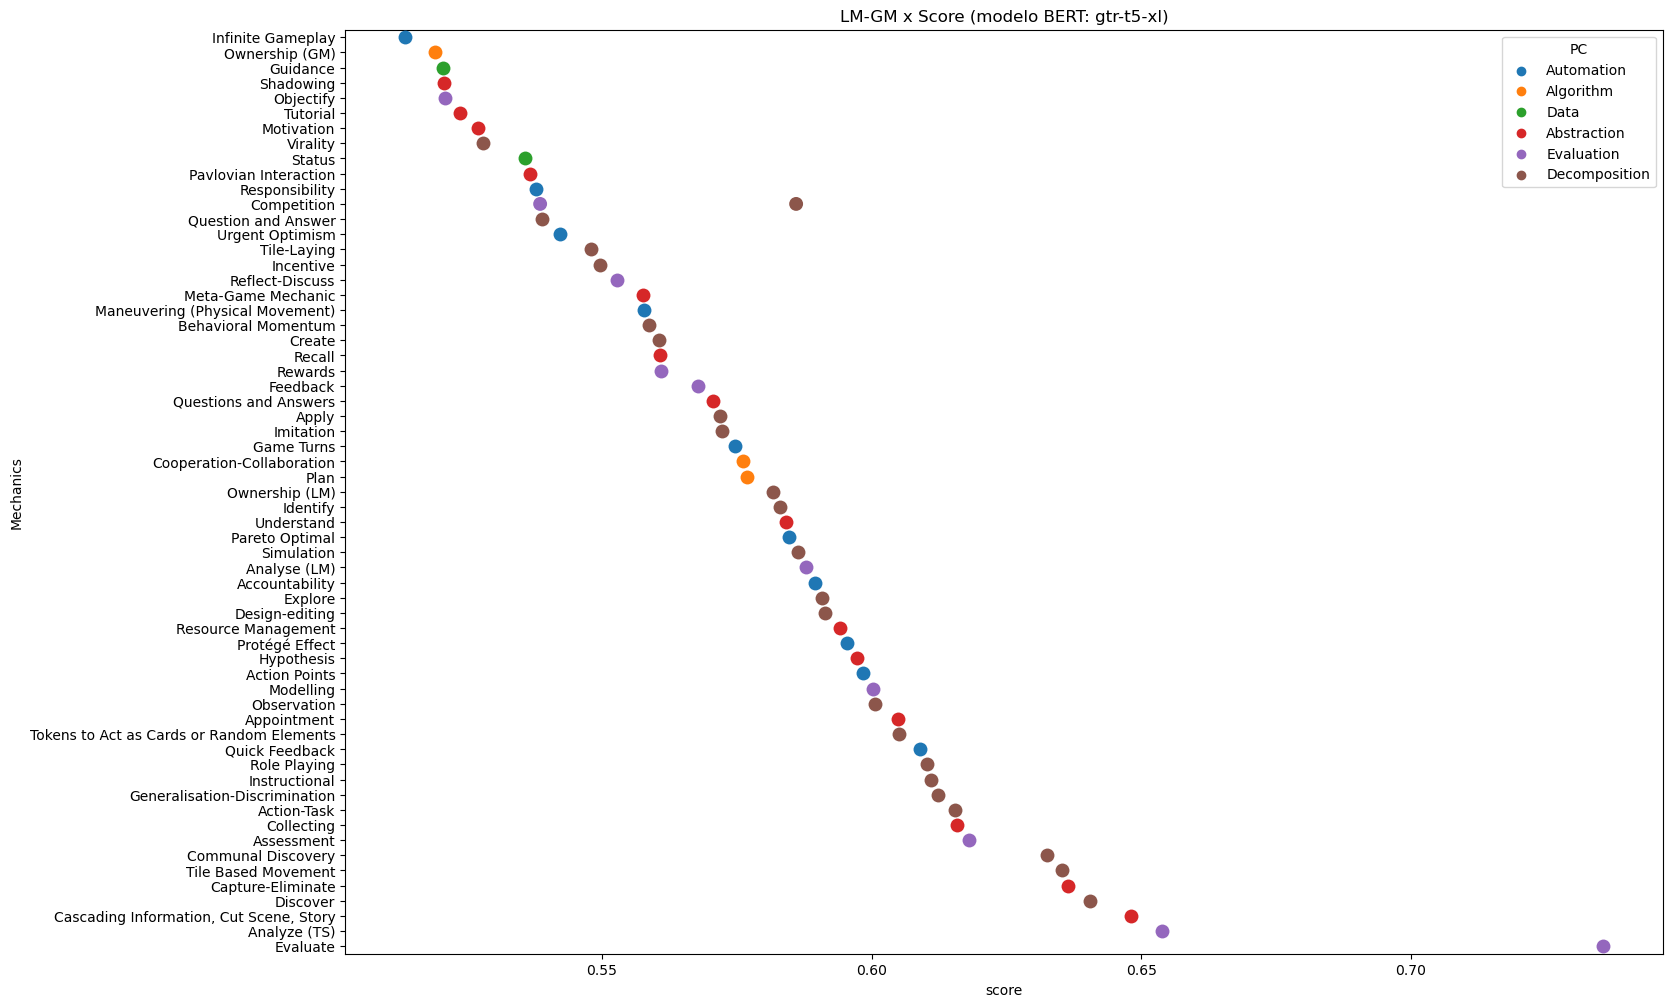

In [31]:
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title("LM-GM x Score (modelo BERT: " + MODELSCOS[modeloEscolhido] + ")")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=dfPrimeiro, x="score", y="Mechanics", hue="PC",size=10)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot.pdf', bbox_inches='tight')

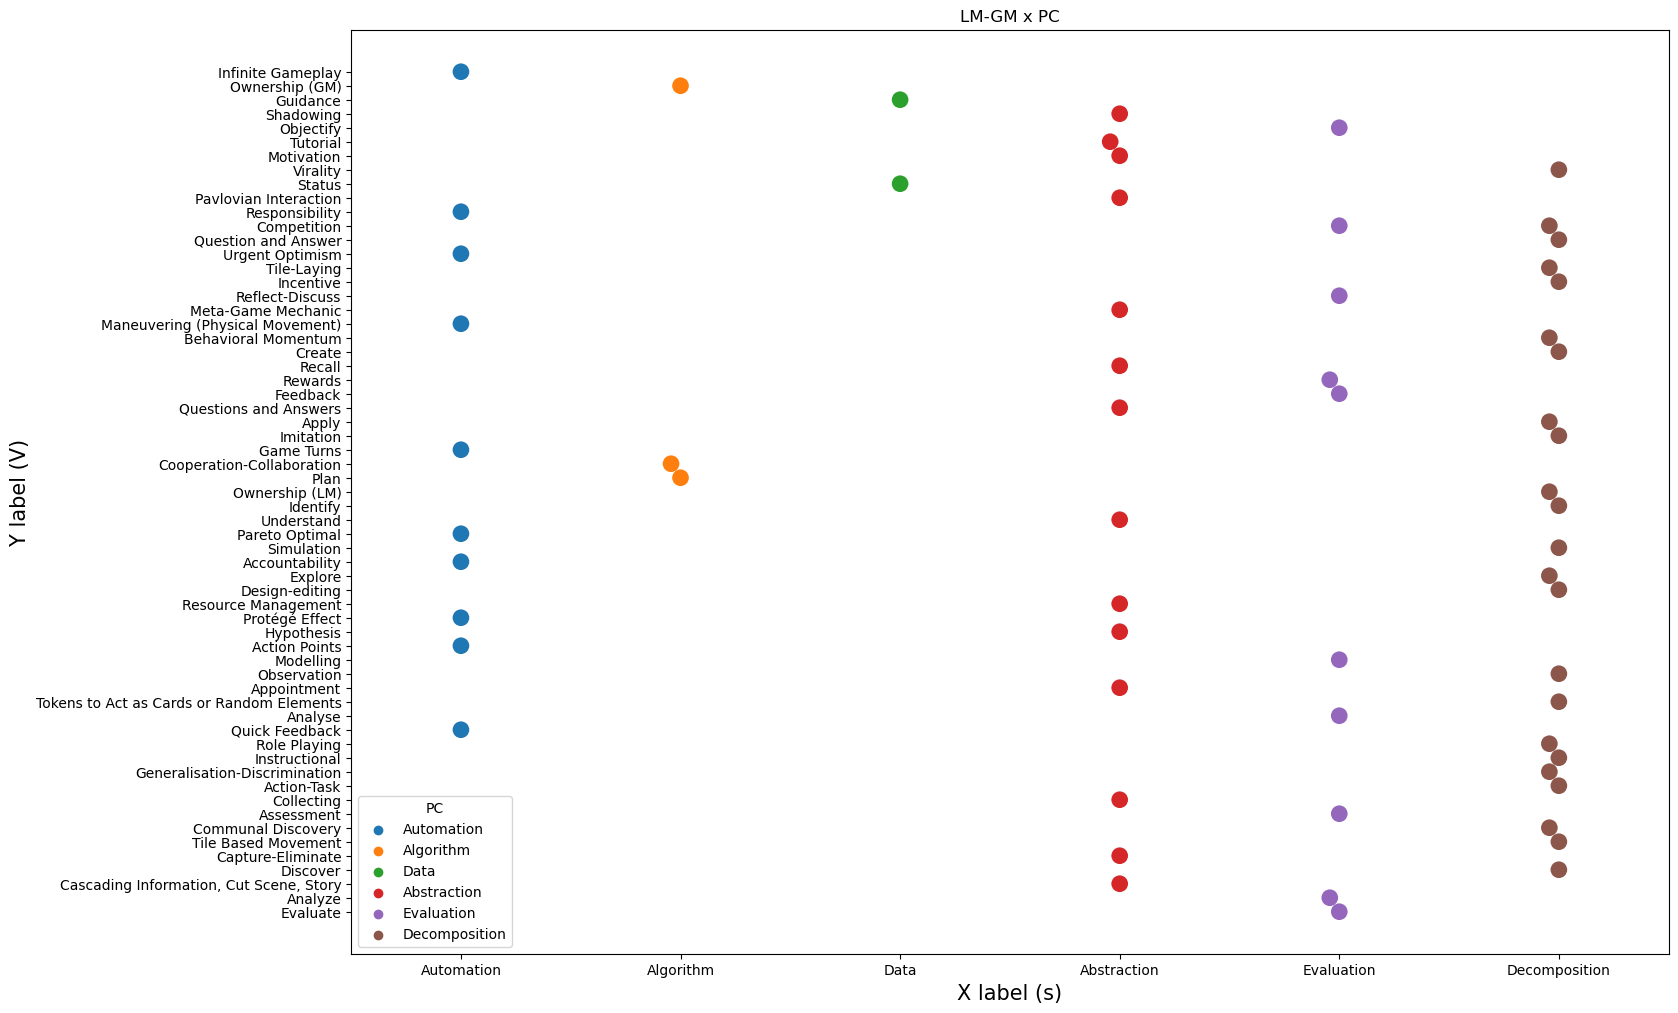

In [17]:
df = dfPrimeiro.copy('deep')
# Draw a heatmap with the numeric values in each cell
#dados = df.pivot('GM', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title("LM-GM x PC")
#sns.heatmap(dados, annot=True,  linewidths=.2, ax=ax,cmap="BuPu")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=df, x="PC", y="Mechanics", hue="PC",size=12)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.xlabel('X label (s)', fontsize=15)
plt.ylabel('Y label (V)', fontsize=15)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarmplot2.pdf', bbox_inches='tight')

# Wordcloud

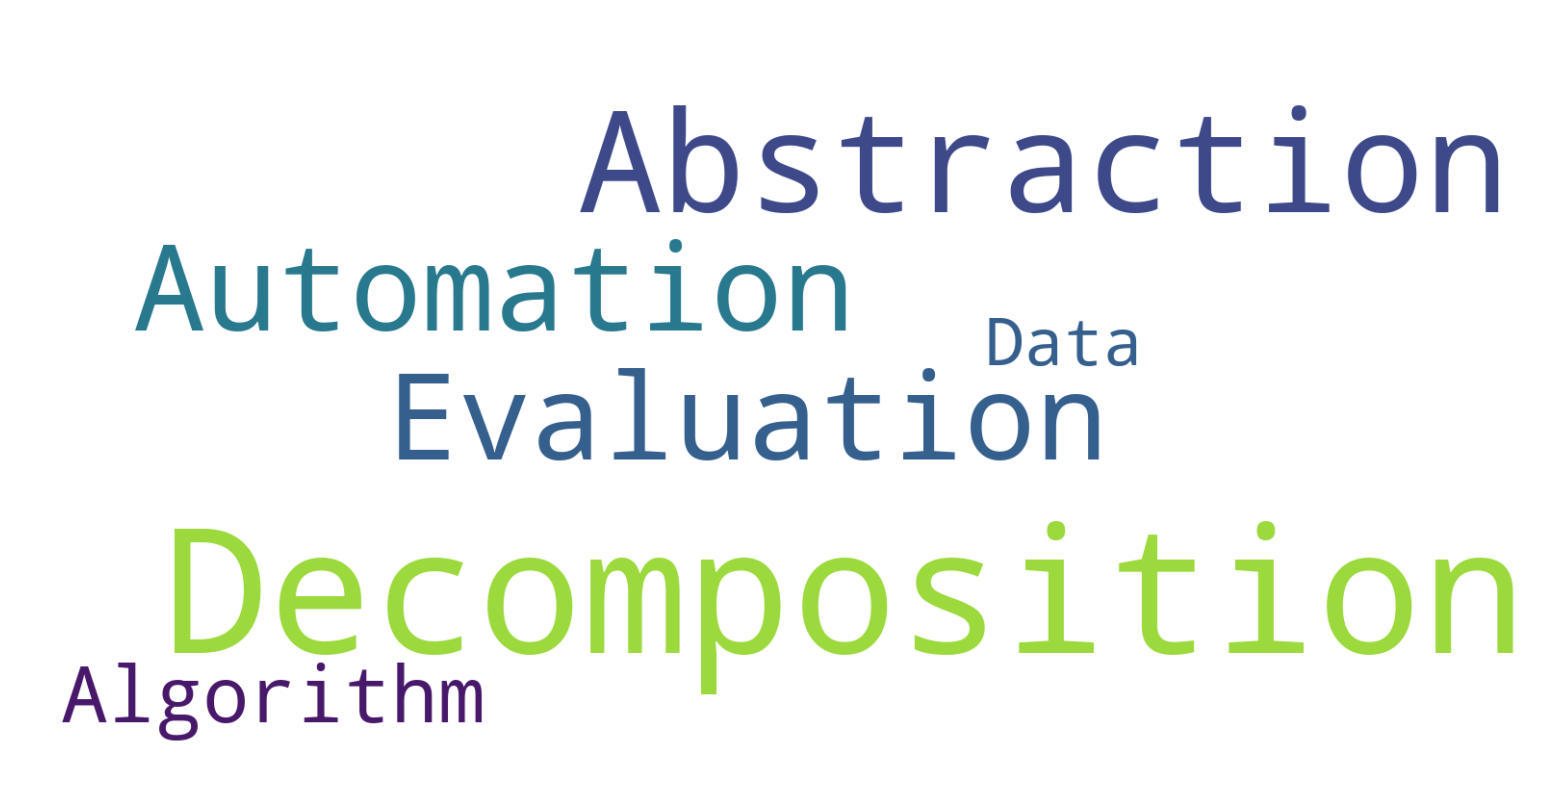

<Figure size 640x480 with 0 Axes>

In [131]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(PC for PC in df.PC)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud.pdf', bbox_inches='tight', dpi=300)

# Wordcloud Mech_desc

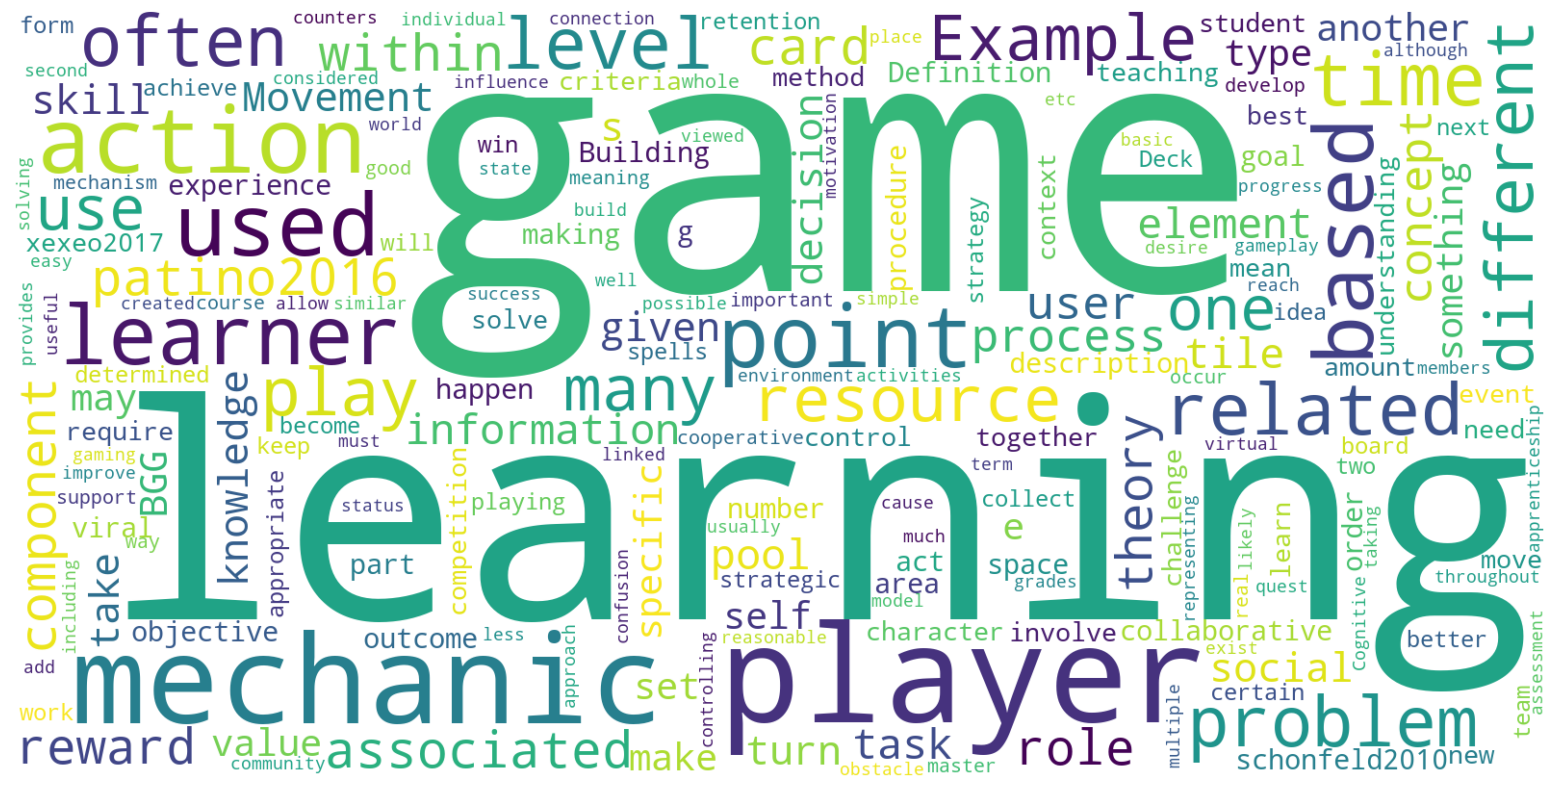

<Figure size 640x480 with 0 Axes>

In [132]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from matplotlib.pyplot import figure
#Importing Dataset

df = dfPrimeiro.copy('deep')
#Creating the text variable

text2 = " ".join(Mech_desc for Mech_desc in df.Mech_desc)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(width=1600, height=800,collocations = False, background_color = 'white').generate(text2)


# Display the generated Word Cloud
plt.figure(figsize=(20,10))
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_wordcloud2.pdf', bbox_inches='tight', dpi=300)

# heatmap 

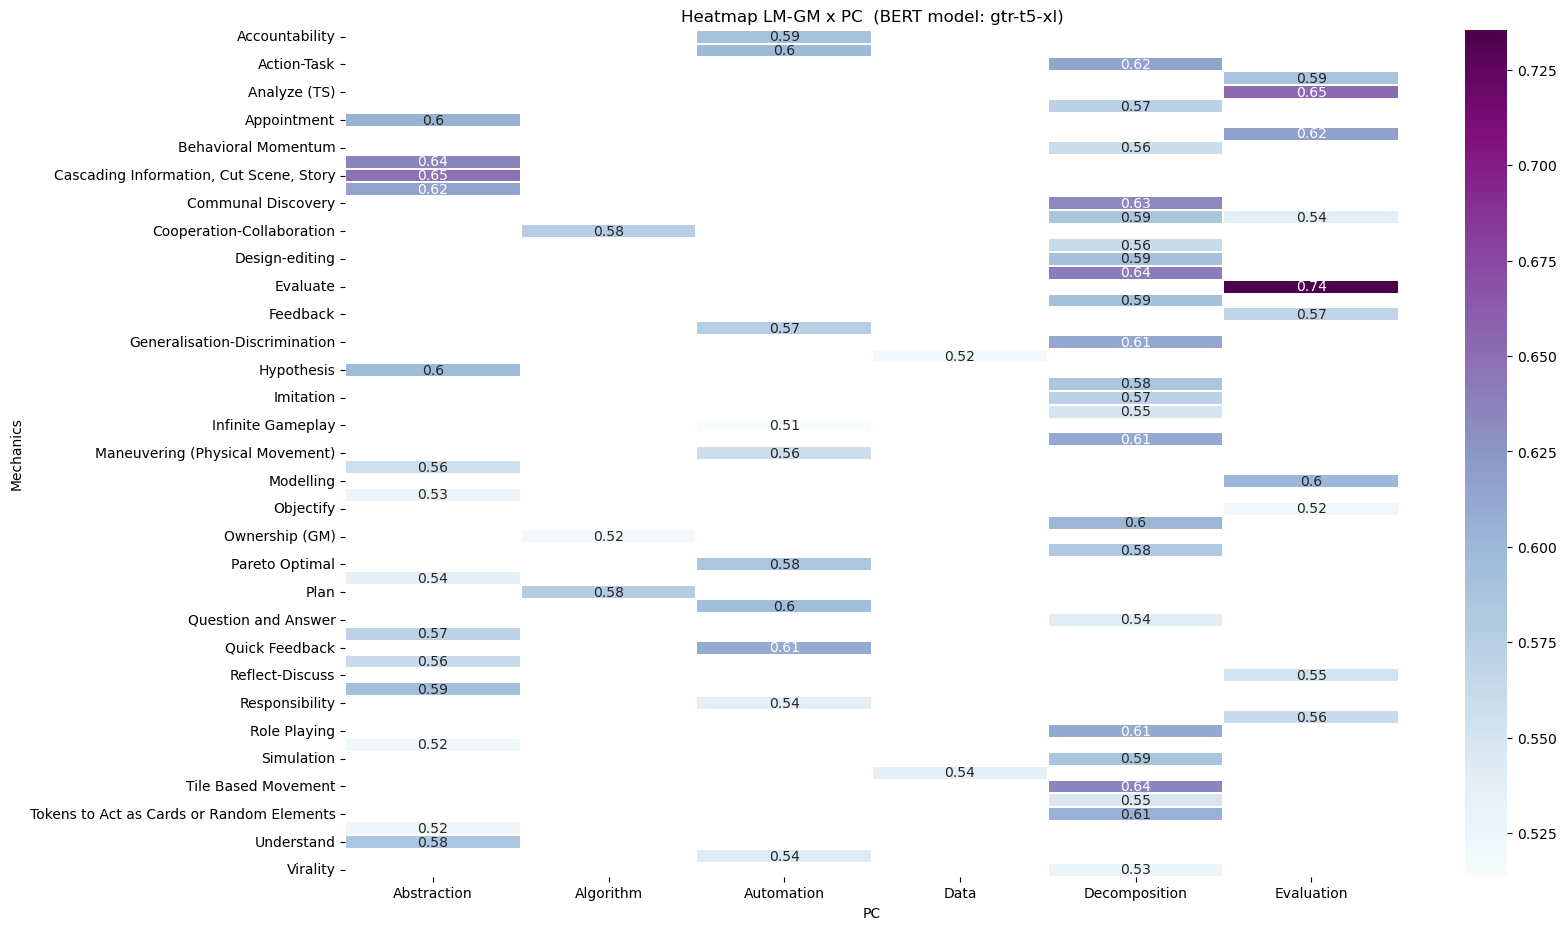

In [33]:
# Draw a heatmap with the numeric values in each cell
df = dfPrimeiro.copy('deep')
dados = df.pivot('Mechanics', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 11))
ax.set_title("Heatmap LM-GM x PC  (BERT model: " + MODELSCOS[modeloEscolhido] + ")")
sns.heatmap(dados, annot=True,  linewidths=.2, ax=ax,cmap="BuPu")
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_heatmap.pdf', bbox_inches='tight', dpi=300)

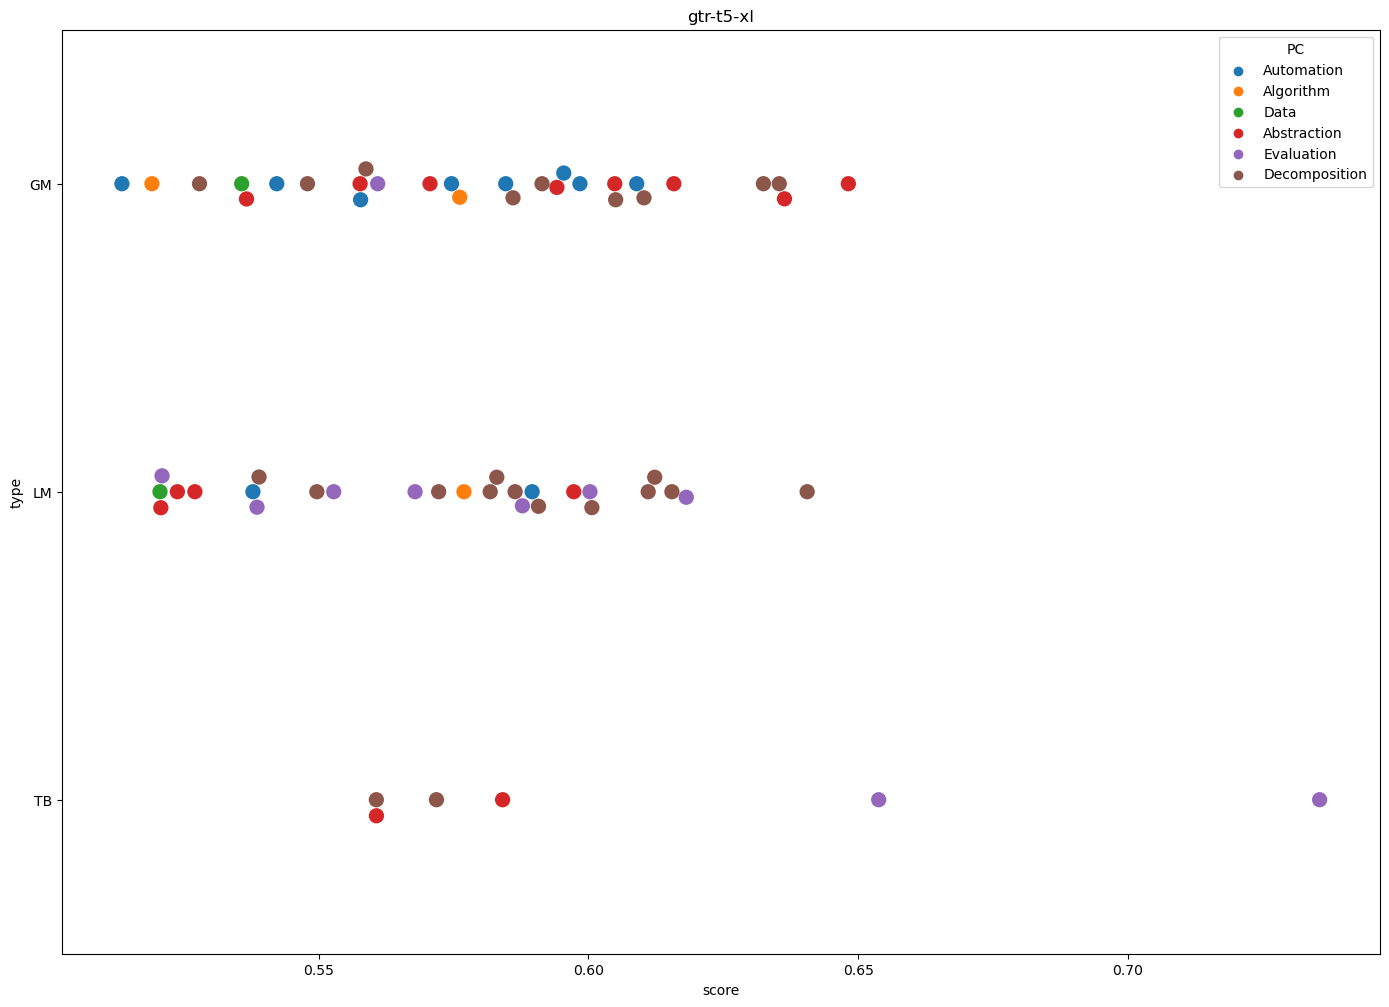

In [26]:
# Draw a heatmap with the numeric values in each cell
#dados = df.pivot('GM', 'PC', 'score')
f, ax = plt.subplots(figsize=(17, 12))
ax.set_title(MODELSCOS[modeloEscolhido])
#sns.heatmap(dados, annot=True,  linewidths=.2, ax=ax,cmap="BuPu")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=df, x="score", y="type", hue="PC",size=11)
plt.savefig(PASTA + MODELSCOS[modeloEscolhido] + '_swarm3.pdf', bbox_inches='tight', dpi=300)

---

---